# Code to Interpolate 3hr data to 1hr

Import Packages

In [1]:
# Third-party packages
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pandas import datetime
import h5pyd
import rex
from sklearn.cluster import KMeans
from sklearn import metrics
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt

import h5py
import time
from scipy.interpolate import interp1d
from scipy.spatial import cKDTree
from tqdm.notebook import trange, tqdm
from sklearn.cluster import KMeans
import seaborn as sns 


/var/folders/bd/5zkgv6rx32s3b0jx_9373xhc0000gn/T/ipykernel_56634/2268736441.py:5: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  from pandas import datetime


Load Wave Data

In [4]:
#path should point to where your 3-hr wave data is stored in your computer
path = '/Users/nataliagonzalez/Documents/UCSD PhD/2022/Research 2022/Wave Energy/wave_time_series/wave_data_syn_west_2006.csv'
wave_data_2006 = pd.read_csv(path, index_col='time', parse_dates=True)
wave_data_2006.rename(columns={'loc_id':'site'},inplace=True)
wave_data_2006

,site,lat,lon,significant_wave_height_m,peak_period_s,capacity_factor
time,,,,,,
2006-01-01 00:00:00+00:00,0,48.8641,-125.386,2.25711,12.1150,0.320274
2006-01-01 03:00:00+00:00,0,48.8641,-125.386,2.27147,12.1150,0.324911
2006-01-01 06:00:00+00:00,0,48.8641,-125.386,2.30218,12.1150,0.334827
2006-01-01 09:00:00+00:00,0,48.8641,-125.386,2.30778,12.1150,0.336636
2006-01-01 12:00:00+00:00,0,48.8641,-125.386,2.32414,12.1150,0.341918
...,...,...,...,...,...,...
2006-12-31 09:00:00+00:00,699000,37.5328,-122.149,0.00000,16.1260,0.000000
2006-12-31 12:00:00+00:00,699000,37.5328,-122.149,0.00000,14.6597,0.000000
2006-12-31 15:00:00+00:00,699000,37.5328,-122.149,0.00000,14.6597,0.000000


Visualizing the difference between 3- and 1-hour resolution data

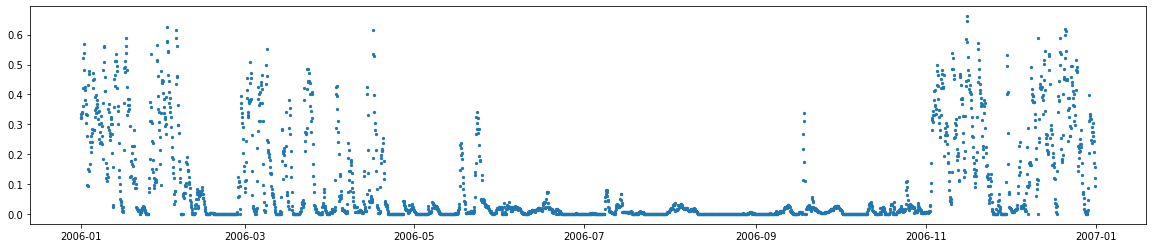

In [8]:
#plot 3-hr annual capacity factor data for site 0
plt.rcParams["figure.figsize"] = (20,4)
plt.scatter(wave_data_2006[wave_data_2006['site']== 0].index,wave_data_2006[wave_data_2006['site']== 0]['capacity_factor'], s=5)

In [9]:
#create 1-hr upsampled/interpolated annual capacity factor data for site 0
upsampled = wave_data_2006[wave_data_2006['site']== 0].resample('1h').interpolate()
#upsampled

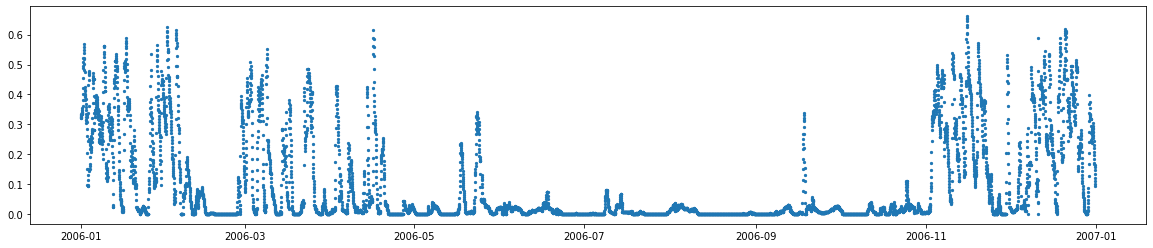

In [10]:
#plot 1-hr upsampled/interpolated annual capacity factor data for site 0
plt.rcParams["figure.figsize"] = (20,4)
plt.scatter(upsampled.index,upsampled['capacity_factor'], s=5)

In [14]:
#this block interpolates the data from 3- to 1-hour time resolution for each site ID
ids = wave_data_2006['site'].unique()
for s in ids:
    upsample = wave_data_2006.copy()
    upsample = upsample[upsample['site']== s].resample('h').interpolate()

    #copying values from the last hour of the set twice (21:00)
    #note that 8757 is the length of 1 set (1 site) of my interpolated data, this may need to be changed
    new = upsample.append(upsample.iloc[[8757]]) 
    new = new.append(upsample.iloc[[8757]])
    new = new.reset_index(drop=False)

    #changing the time of the last 2 copied lines to (22:00) and (23:00) to get a full day
    new['time'].iloc[[8758]] = upsample.iloc[[8757]].index + pd.DateOffset(hours=1)
    new['time'].iloc[[8759]] = upsample.iloc[[8757]].index + pd.DateOffset(hours=2)
    new = new.set_index('time', drop=True)

    #concatenating each interpolated set
    if (s==0):
        wave_data = new.copy()
    else:
        wave_data = pd.concat([wave_data, new])
wave_data

/var/folders/bd/5zkgv6rx32s3b0jx_9373xhc0000gn/T/ipykernel_56634/1132576452.py:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new = upsample.append(upsample.iloc[[8757]])
/var/folders/bd/5zkgv6rx32s3b0jx_9373xhc0000gn/T/ipykernel_56634/1132576452.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new = new.append(upsample.iloc[[8757]])
/var/folders/bd/5zkgv6rx32s3b0jx_9373xhc0000gn/T/ipykernel_56634/1132576452.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new['time'].iloc[[8758]] = upsample.iloc[[8757]].index + pd.DateOffset(hours=1)
/var/folders/bd/5zkgv6rx32s3b0jx_9373xhc0000gn/T/ipykernel_56634/1132576452.py:8: Sett

,site,lat,lon,significant_wave_height_m,peak_period_s,capacity_factor
time,,,,,,
2006-01-01 00:00:00+00:00,0.0,48.8641,-125.386,2.257110,12.1150,0.320274
2006-01-01 01:00:00+00:00,0.0,48.8641,-125.386,2.261897,12.1150,0.321820
2006-01-01 02:00:00+00:00,0.0,48.8641,-125.386,2.266683,12.1150,0.323366
2006-01-01 03:00:00+00:00,0.0,48.8641,-125.386,2.271470,12.1150,0.324911
2006-01-01 04:00:00+00:00,0.0,48.8641,-125.386,2.281707,12.1150,0.328217
...,...,...,...,...,...,...
2006-12-31 19:00:00+00:00,699000.0,37.5328,-122.149,0.000000,14.6597,0.000000
2006-12-31 20:00:00+00:00,699000.0,37.5328,-122.149,0.000000,14.6597,0.000000
2006-12-31 21:00:00+00:00,699000.0,37.5328,-122.149,0.000000,14.6597,0.000000


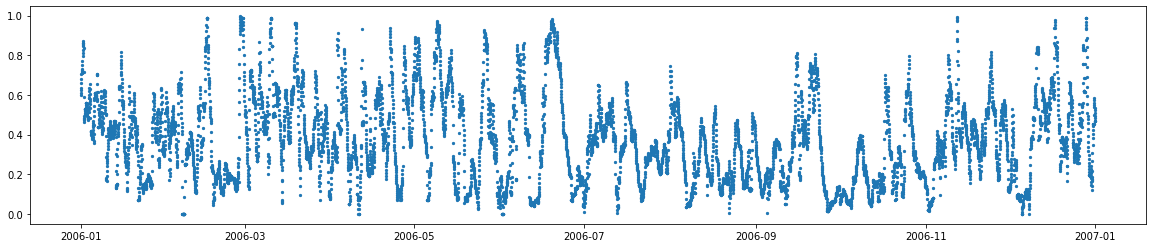

In [ ]:
#visualizing a fully interpolated set (site 0)
plt.rcParams["figure.figsize"] = (20,4)
plt.scatter(wave_data[wave_data['site']== 0].index,wave_data[wave_data['site']== 0]['capacity_factor'], s=5)

In [ ]:
#output_path should point to where you want to save the final interpolated wave data
output_path='/Users/nataliagonzalez/Documents/UCSD PhD/2022/Research 2022/Wave Energy/wave_time_series/wave_data_syn_2006_3_hr.csv'
wave_data.to_csv(output_path,index=True)